In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import os
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# folder_path="/content/drive/MyDrive/current/ML-project/dataTop/5_image/"
# folder_path="/content/drive/MyDrive/ML-project/dataTop5_image/"
folder_path='/content/drive/MyDrive/current/ML-project/dataTop5_image/'
na_class=os.listdir(folder_path)
print(na_class)

['comrav', 'houspa', 'houwre', 'redcro', 'sonspa']


In [5]:
X=[]
Y=[]
# image_size=226
i=0
for cl in na_class:
  clpath=folder_path+cl
  names=os.listdir(clpath)
  for n in names:
    rpath=clpath+"/"+n
    # img=cv2.imread(rpath,0)
    # img=cv2.resize(img, (image_size, image_size))
    # X.append(img)
    X.append(rpath)
    Y.append(i)
  i+=1
X=np.asarray(X)
Y=np.asarray(Y)

In [6]:
print(len(Y))

3830


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=12)
# print(len(x_train))

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(224, padding=4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

class cDataset(Dataset):
    def __init__(self, root, labels, transform=None):
      self.root = root
      self.labels = labels
      self.transform = transform
        
    def __len__(self):
      return len(self.labels)
        
    def __getitem__(self, index):
      path = self.root[index]
      label = self.labels[index]
      with open(path, 'rb') as f:
        sample = Image.open(f).convert('RGB')
        # sample = Image.open(f).convert('L')
      if self.transform is not None:
        sample = self.transform(sample)
      return sample, label

In [10]:
print(x_train[0])

/content/drive/MyDrive/current/ML-project/dataTop5_image/comrav/XC130433.png


In [11]:
trainset = cDataset(x_train, y_train, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True,drop_last = True)

testset = cDataset(x_test, y_test, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, drop_last = True)


In [12]:
print(len(trainset))
n_total_steps = len(trainloader)
print(n_total_steps)

3447
215


In [13]:
for b_idx, (inputs, targets) in enumerate(trainloader):
  print(b_idx)
  # print(inputs)
  print(targets)
  break

0
tensor([3, 0, 0, 0, 4, 0, 4, 2, 2, 3, 4, 0, 3, 4, 2, 3])


In [23]:
torch.cuda.is_available() 

True

In [17]:
# https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# model = models.resnet34(pretrained=True)
# 18
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
from torch import nn
from torch import optim
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 5),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
epochs = 1
steps = 0
running_loss = 0
# print_every = 10
print_every = 20
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Step {steps} Epoch {epoch+1}/{epochs}.. ")
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Step 1 Epoch 1/1.. 
Step 2 Epoch 1/1.. 
Step 3 Epoch 1/1.. 
Step 4 Epoch 1/1.. 
Step 5 Epoch 1/1.. 
Step 6 Epoch 1/1.. 
Step 7 Epoch 1/1.. 
Step 8 Epoch 1/1.. 
Step 9 Epoch 1/1.. 
Step 10 Epoch 1/1.. 
Step 11 Epoch 1/1.. 
Step 12 Epoch 1/1.. 
Step 13 Epoch 1/1.. 
Step 14 Epoch 1/1.. 
Step 15 Epoch 1/1.. 
Step 16 Epoch 1/1.. 
Step 17 Epoch 1/1.. 
Step 18 Epoch 1/1.. 
Step 19 Epoch 1/1.. 
Step 20 Epoch 1/1.. 
Epoch 1/1.. Train loss: 1.215.. Test loss: 1.168.. Test accuracy: 0.538
Step 21 Epoch 1/1.. 
Step 22 Epoch 1/1.. 
Step 23 Epoch 1/1.. 
Step 24 Epoch 1/1.. 
Step 25 Epoch 1/1.. 
Step 26 Epoch 1/1.. 
Step 27 Epoch 1/1.. 
Step 28 Epoch 1/1.. 
Step 29 Epoch 1/1.. 
Step 30 Epoch 1/1.. 
Step 31 Epoch 1/1.. 
Step 32 Epoch 1/1.. 
Step 33 Epoch 1/1.. 
Step 34 Epoch 1/1.. 
Step 35 Epoch 1/1.. 
Step 36 Epoch 1/1.. 
Step 37 Epoch 1/1.. 
Step 38 Epoch 1/1.. 
Step 39 Epoch 1/1.. 
Step 40 Epoch 1/1.. 
Epoch 1/1.. Train loss: 1.533.. Test loss: 1.404.. Test accuracy: 0.421
Step 41 Epoch 1/1.. 
Step

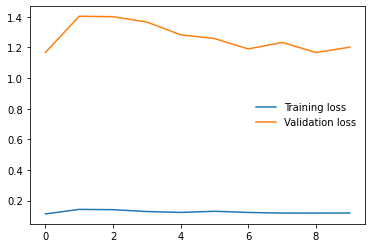

In [25]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [26]:
epochs = 10
steps = 0
running_loss = 0
# print_every = 10
print_every = 20
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Step {steps} Epoch {epoch+1}/{epochs}.. ")
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Step 1 Epoch 1/10.. 
Step 2 Epoch 1/10.. 
Step 3 Epoch 1/10.. 
Step 4 Epoch 1/10.. 
Step 5 Epoch 1/10.. 
Step 6 Epoch 1/10.. 
Step 7 Epoch 1/10.. 
Step 8 Epoch 1/10.. 
Step 9 Epoch 1/10.. 
Step 10 Epoch 1/10.. 
Step 11 Epoch 1/10.. 
Step 12 Epoch 1/10.. 
Step 13 Epoch 1/10.. 
Step 14 Epoch 1/10.. 
Step 15 Epoch 1/10.. 
Step 16 Epoch 1/10.. 
Step 17 Epoch 1/10.. 
Step 18 Epoch 1/10.. 
Step 19 Epoch 1/10.. 
Step 20 Epoch 1/10.. 
Epoch 1/10.. Train loss: 1.308.. Test loss: 1.135.. Test accuracy: 0.527
Step 21 Epoch 1/10.. 
Step 22 Epoch 1/10.. 
Step 23 Epoch 1/10.. 
Step 24 Epoch 1/10.. 
Step 25 Epoch 1/10.. 
Step 26 Epoch 1/10.. 
Step 27 Epoch 1/10.. 
Step 28 Epoch 1/10.. 
Step 29 Epoch 1/10.. 
Step 30 Epoch 1/10.. 
Step 31 Epoch 1/10.. 
Step 32 Epoch 1/10.. 
Step 33 Epoch 1/10.. 
Step 34 Epoch 1/10.. 
Step 35 Epoch 1/10.. 
Step 36 Epoch 1/10.. 
Step 37 Epoch 1/10.. 
Step 38 Epoch 1/10.. 
Step 39 Epoch 1/10.. 
Step 40 Epoch 1/10.. 
Epoch 1/10.. Train loss: 1.107.. Test loss: 1.090.. Test

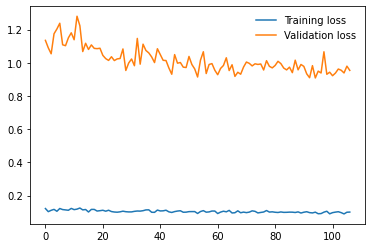

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
model.eval()

# def predict_image(image):
#     image_tensor = test_transforms(image).float()
#     image_tensor = image_tensor.unsqueeze_(0)
#     input = Variable(image_tensor)
#     input = input.to(device)
#     output = model(input)
#     index = output.data.cpu().numpy().argmax()
#     return index

output = model(input)
index = output.data.cpu().numpy().argmax()

In [ ]:
# https://medium.datadriveninvestor.com/creating-a-pytorch-image-classifier-da9db139ba80